In [2]:
!nvidia-smi

Sun Dec 12 18:51:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os 
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import normalize
from PIL import Image 
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import adam_v2
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
n_classes = 1
image_directory = "/content/drive/My Drive/images/images_train_dataset/"
mask_directory = "/content/drive/My Drive/images/images_masks_dataset/"
num_images = len(glob.glob("/content/drive/My Drive/images/images_train_dataset/*.jpg"))
SIZE = (256,256)

In [5]:
image_names = glob.glob(image_directory + "*jpg")
image_names.sort()
images = [(cv2.imread(img, 0)) for img in image_names]
images_resized = [cv2.resize(img, SIZE, interpolation = cv2.INTER_AREA) for img in images]
images_dataset = np.array(images_resized)
images_dataset = np.expand_dims(images_dataset, axis = 3)

In [6]:
mask_names = glob.glob(mask_directory + "*.tiff")
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
masks_resized = [cv2.resize(mask, SIZE, interpolation = cv2.INTER_AREA) for mask in masks]
masks_dataset = np.array(masks_resized)
masks_dataset = np.expand_dims(masks_dataset, axis = 3)

In [7]:
print("Image data: ", images_dataset.shape)
print("Mask data: ", masks_dataset.shape)
print("Max pixel value: ", images_dataset.max())
print("Labels: ", np.unique(masks_dataset))

Image data:  (54, 256, 256, 1)
Mask data:  (54, 256, 256, 1)
Max pixel value:  254
Labels:  [0 1]


In [8]:
images_dataset = images_dataset/255. 

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_dataset, masks_dataset, test_size = 53, random_state = 42)

<function matplotlib.pyplot.show>

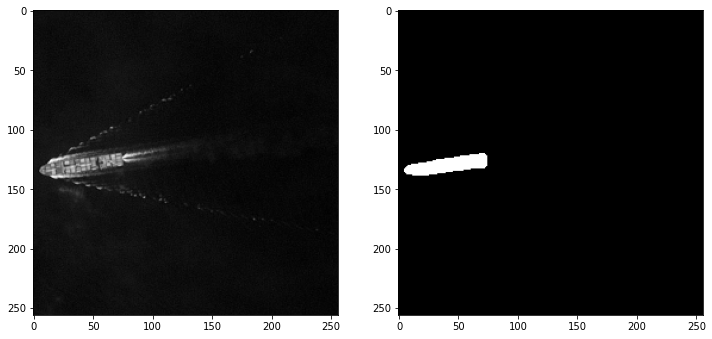

In [10]:
import random 
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap="gray")
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap="gray")
plt.show

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import adam_v2
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x,p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_unet(input_shape, n_classes):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  activation = "sigmoid"

  outputs = Conv2D(n_classes, 1, padding="same", activation = activation)(d4)

  model = Model(inputs, outputs, name = "U-Net")
  return model



In [12]:
IMG_HEIGHT = images_dataset.shape[1]
IMG_WIDTH = images_dataset.shape[2]
IMG_CHANNELS = images_dataset.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes = 1)
model.compile(optimizer= adam_v2.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 256, 256, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_91 (BatchN  (None, 256, 256, 64  256        ['conv2d_96[0][0]']              
 ormalization)                  )                                                             

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose = 1,
                    epochs = 500,
                    validation_data = (X_test, y_test),
                    shuffle = False)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.3481 - accuracy: 0.9869 - val_loss: 0.6733 - val_accuracy: 0.6889
Epoch 2/500
1/1 [==============================] - 1s 1s/step - loss: 0.3462 - accuracy: 0.9871 - val_loss: 0.6725 - val_accuracy: 0.6915
Epoch 3/500
1/1 [==============================] - 1s 1s/step - loss: 0.3443 - accuracy: 0.9872 - val_loss: 0.6716 - val_accuracy: 0.6942
Epoch 4/500
1/1 [==============================] - 1s 1s/step - loss: 0.3424 - accuracy: 0.9874 - val_loss: 0.6707 - val_accuracy: 0.6969
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 0.3405 - accuracy: 0.9877 - val_loss: 0.6698 - val_accuracy: 0.6995
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 0.3386 - accuracy: 0.9879 - val_loss: 0.6688 - val_accuracy: 0.7021
Epoch 7/500
1/1 [==============================] - 1s 1s/step - loss: 0.3368 - accuracy: 0.9880 - val_loss: 0.6679 - val_accuracy: 0.7048
Epoch 8/500
1/1 [=================

In [ ]:
model.save("/content/drive/My Drive/unet_model/unet_model_bin_100ep.hdf5")

In [13]:
from keras.models import load_model
model = load_model("/content/drive/My Drive/unet_model/unet_model_bin_100ep.hdf5")

In [14]:
import tensorflow as tf
from keras import backend as K
y_pred = model.predict(X_test)
y_pred_thresh = y_pred > 0.5
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(tf.cast(y_true,tf.float32,None), axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice*100

print(dice_coef(y_test, y_pred))

tf.Tensor(2.7027998, shape=(), dtype=float32)


(1, 256, 256, 1)
(256, 256)


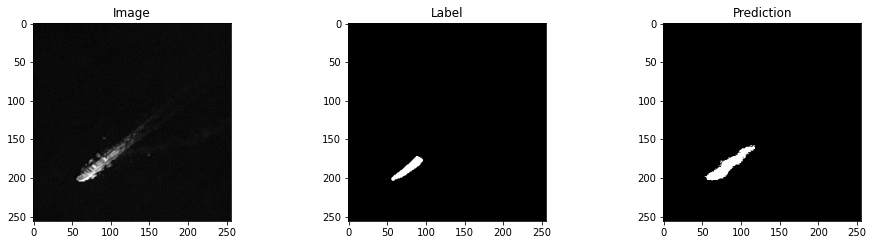

In [16]:
thresh = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.8).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title("Image")
plt.imshow(test_img[:,:,0], cmap="gray")
plt.subplot(232)
plt.title("Label")
plt.imshow(ground_truth[:,:,0], cmap="gray")
plt.subplot(233)
plt.title("Prediction")
plt.imshow(prediction, cmap="gray")